# 데이터 로드

In [147]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import shap
import random

random.seed(42)
np.random.seed(42)


plt.rcParams['font.family'] = ['Malgun Gothic', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False



In [148]:
df = pd.read_csv('data_2.csv', dtype={'isbn': str})
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3316 entries, 0 to 3315
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   isbn               3316 non-null   object 
 1   title              3316 non-null   object 
 2   publishDate        3316 non-null   int64  
 3   price              3316 non-null   int64  
 4   pageCount          3316 non-null   int64  
 5   size               3316 non-null   float64
 6   weight             3316 non-null   int64  
 7   label              3316 non-null   int64  
 8   author_name_tf     3316 non-null   int64  
 9   publisher_name_tf  3316 non-null   int64  
dtypes: float64(1), int64(7), object(2)
memory usage: 259.2+ KB


In [149]:
df.head()
df.describe()
df.isnull().sum()

isbn                 0
title                0
publishDate          0
price                0
pageCount            0
size                 0
weight               0
label                0
author_name_tf       0
publisher_name_tf    0
dtype: int64

In [150]:
# 두 CSV 파일 불러오기 (isbn을 문자열로 처리)
keyword_best = pd.read_csv('book_with_entropy.csv', dtype={'isbn': str})
keyword_book = pd.read_csv('일반도서 entropy.csv', dtype={'isbn': str})

# 컬럼 이름 확인
best_columns = keyword_best.columns.tolist()
book_columns = keyword_book.columns.tolist()

best_columns, book_columns

(['topic_0',
  'topic_1',
  'topic_2',
  'topic_3',
  'topic_4',
  'topic_5',
  'isbn',
  'entropy'],
 ['topic_0',
  'topic_1',
  'topic_2',
  'topic_3',
  'topic_4',
  'topic_5',
  'isbn',
  'entropy'])

In [151]:
df_best = df[df['label'] == 1].copy()
df_book = df[df['label'] == 0].copy()

print("베스트셀러 수:", len(df_best))
print("일반 도서 수:", len(df_book))

베스트셀러 수: 1000
일반 도서 수: 2316


In [152]:
df_best = df_best.merge(keyword_best, on='isbn', how='left')
df_book = df_book.merge(keyword_book, on='isbn', how='left')

In [153]:
df = pd.concat([df_best, df_book], ignore_index=True)
print(df.shape)

(3316, 17)


# 이상치

# XGB

In [154]:
# 토픽 컬럼 리스트
topic_cols = ['topic_0', 'topic_1', 'topic_2', 'topic_3', 'topic_4', 'topic_5']

# 토픽 컬럼 중 하나라도 결측치가 있으면 그 행 제거
df = df.dropna(subset=topic_cols).reset_index(drop=True)

In [155]:
# 지수변환, 엔트로피
# 1. 토픽값에 지수 변환 (exp, 0값 방지용 eps 추가)
eps = 1e-5
for col in topic_cols:
    df[col + '_exp'] = np.exp(df[col].replace(0, eps) + eps)

# 2. 엔트로피 정규화 (0~1)
max_entropy = np.log2(len(topic_cols))
df['entropy_norm'] = df['entropy'] / max_entropy

# 3. 1 - 엔트로피 정규화값 계산
df['inv_entropy'] = 1 - df['entropy_norm']

# 4. k제곱 후, 지수 변환된 토픽값에 곱하기
k = 1
for col in topic_cols:
    df[f'{col}_ent'] = df[col + '_exp'] * (df['inv_entropy'] ** k)

# 5. 기존 토픽 컬럼, 엔트로피 관련 컬럼, 지수 변환만 한 컬럼 제외
drop_cols = topic_cols + ['entropy', 'entropy_norm', 'inv_entropy'] + [col + '_exp' for col in topic_cols]
X = df.drop(columns=drop_cols + ['isbn', 'title', 'label'])
y = df['label']

# 6. 결과 확인
print("최종 학습셋 피처 목록:", X.columns.tolist())
print(X[[f'{col}_ent' for col in topic_cols]].head())


최종 학습셋 피처 목록: ['publishDate', 'price', 'pageCount', 'size', 'weight', 'author_name_tf', 'publisher_name_tf', 'topic_0_ent', 'topic_1_ent', 'topic_2_ent', 'topic_3_ent', 'topic_4_ent', 'topic_5_ent']
   topic_0_ent  topic_1_ent  topic_2_ent  topic_3_ent  topic_4_ent  \
0     0.916387     0.913930     0.916651     0.916384     0.915493   
1     0.493764     0.939636     0.493784     0.574116     0.603887   
2     0.653680     0.653480     0.653702     1.324400     0.653607   
3     0.972937     2.623111     0.973009     0.972937     0.972695   
4     0.634834     0.634478     1.245323     0.874361     0.634705   

   topic_5_ent  
0     2.414208  
1     0.493637  
2     0.873885  
3     0.972463  
4     0.634581  


In [156]:
from sklearn.model_selection import train_test_split
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=1/3, random_state=42, stratify=y_temp
)

print("Train shape:", X_train.shape)
print("Validation shape:", X_val.shape)
print("Test shape:", X_test.shape)
print("최종 feature 목록:", X_train.columns.tolist())

Train shape: (1138, 13)
Validation shape: (326, 13)
Test shape: (163, 13)
최종 feature 목록: ['publishDate', 'price', 'pageCount', 'size', 'weight', 'author_name_tf', 'publisher_name_tf', 'topic_0_ent', 'topic_1_ent', 'topic_2_ent', 'topic_3_ent', 'topic_4_ent', 'topic_5_ent']


[I 2025-06-09 20:46:09,200] A new study created in memory with name: no-name-57323c41-dff2-47a6-af9e-01fd725ee43b


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-06-09 20:46:09,310] Trial 0 finished with value: 0.911042944785276 and parameters: {'max_depth': 5, 'learning_rate': 0.1540359659501924, 'subsample': 0.7587945476302645, 'colsample_bytree': 0.6387926357773329, 'gamma': 1.2481491235394921, 'min_child_weight': 2, 'reg_alpha': 0.11616722433639892, 'reg_lambda': 17.323522915498703, 'n_estimators': 1301, 'scale_pos_weight': 1.7080725777960455}. Best is trial 0 with value: 0.911042944785276.
[I 2025-06-09 20:46:09,458] Trial 1 finished with value: 0.9171779141104295 and parameters: {'max_depth': 3, 'learning_rate': 0.17052641538983093, 'subsample': 0.8491983767203796, 'colsample_bytree': 0.29110519961044856, 'gamma': 1.454599737656805, 'min_child_weight': 2, 'reg_alpha': 0.6084844859190754, 'reg_lambda': 10.495128632644757, 'n_estimators': 1216, 'scale_pos_weight': 1.291229140198042}. Best is trial 1 with value: 0.9171779141104295.
[I 2025-06-09 20:46:10,024] Trial 2 finished with value: 0.8619631901840491 and parameters: {'max_depth

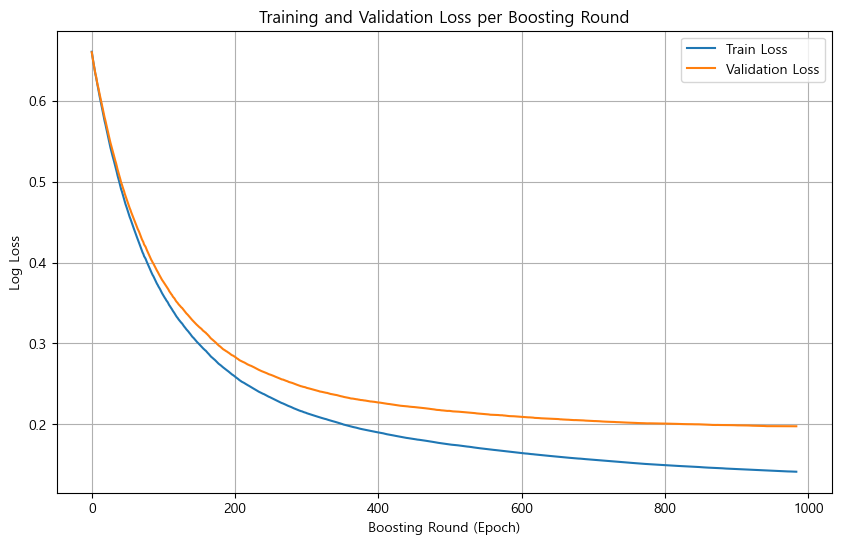


==== XGB_baseline ====
[[110  15]
 [ 12 189]]
              precision    recall  f1-score   support

           0       0.90      0.88      0.89       125
           1       0.93      0.94      0.93       201

    accuracy                           0.92       326
   macro avg       0.91      0.91      0.91       326
weighted avg       0.92      0.92      0.92       326


==== XGB_optuna ====
[[114  11]
 [  9 192]]
              precision    recall  f1-score   support

           0       0.93      0.91      0.92       125
           1       0.95      0.96      0.95       201

    accuracy                           0.94       326
   macro avg       0.94      0.93      0.93       326
weighted avg       0.94      0.94      0.94       326

Best Params: {'max_depth': 8, 'learning_rate': 0.015044743891851823, 'subsample': 0.7384858405418602, 'colsample_bytree': 0.5699809180042373, 'gamma': 0.8205952730924176, 'min_child_weight': 4, 'reg_alpha': 0.16964027257552233, 'reg_lambda': 12.667547208

In [157]:
import optuna
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import xgboost as xgb
import matplotlib.pyplot as plt

# 1️⃣ 기본 모델 (그대로 유지)
basic_model = xgb.XGBClassifier(eval_metric='logloss', random_state=42, n_jobs=1)
basic_model.fit(X_train, y_train)
y_val_pred_basic = basic_model.predict(X_val)

results = []
results.append({
    'name': 'XGB_baseline',
    'model': basic_model,
    'conf_matrix': confusion_matrix(y_val, y_val_pred_basic),
    'report': classification_report(y_val, y_val_pred_basic, output_dict=False)
})

# 2️⃣ Optuna 목적 함수 (early_stopping_rounds를 생성자로 이동)
def objective(trial):
    params = {
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.2, log=True),
        'subsample': trial.suggest_float('subsample', 0.1, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 8),
        'min_child_weight': trial.suggest_int('min_child_weight', 0, 15),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 2.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 20.0),
        'eval_metric': 'logloss',
        'random_state': 42,
        'n_estimators': trial.suggest_int('n_estimators',1000, 1500),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 1.0, 2.0),
        'early_stopping_rounds': 20  # ✅ 생성자에 추가
    }
    
    model = xgb.XGBClassifier(**params)
    model.fit(
        X_train, y_train,
        eval_set=[(X_train, y_train), (X_val, y_val)],
        verbose=False
    )
    preds = model.predict(X_val, iteration_range=(0, model.best_iteration + 1))
    return accuracy_score(y_val, preds)

from optuna.samplers import TPESampler

sampler = TPESampler(seed=42)
study = optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(objective, n_trials=100, show_progress_bar=True)

# 4️⃣ 최적 모델 학습 (생성자에 early_stopping_rounds 추가)
best_params = study.best_trial.params
best_model = xgb.XGBClassifier(**best_params, eval_metric='logloss', random_state=42, early_stopping_rounds=20)

best_model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],
    verbose=False
)

y_val_pred_tuned = best_model.predict(X_val, iteration_range=(0, best_model.best_iteration + 1))

eval_result = best_model.evals_result_
train_loss = eval_result['validation_0']['logloss']
val_loss = eval_result['validation_1']['logloss']

plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Boosting Round (Epoch)')
plt.ylabel('Log Loss')
plt.title('Training and Validation Loss per Boosting Round')
plt.legend()
plt.grid(True)
plt.show()

results.append({
    'name': 'XGB_optuna',
    'model': best_model,
    'conf_matrix': confusion_matrix(y_val, y_val_pred_tuned),
    'report': classification_report(y_val, y_val_pred_tuned, output_dict=False),
    'best_params': best_params
})

# 5️⃣ 결과 출력
for res in results:
    print(f"\n==== {res['name']} ====")
    print(res['conf_matrix'])
    print(res['report'])
    if 'best_params' in res:
        print("Best Params:", res['best_params'])


In [158]:
# # 원본 데이터 df에서 validation 인덱스만 추출
# isbn_val = df.loc[X_val.index, 'isbn']

# output_df = pd.DataFrame({
#     'isbn': isbn_val.values,
#     'y_pred': y_pred
# })

# output_df.to_csv('y_pred.csv', index=False)


In [159]:
print("Train Accuracy:", accuracy_score(y_train, best_model.predict(X_train)))
print("Val Accuracy:", accuracy_score(y_val, best_model.predict(X_val)))
print("Test Accuracy:", accuracy_score(y_test, best_model.predict(X_test)))

Train Accuracy: 0.9516695957820738
Val Accuracy: 0.9386503067484663
Test Accuracy: 0.9202453987730062


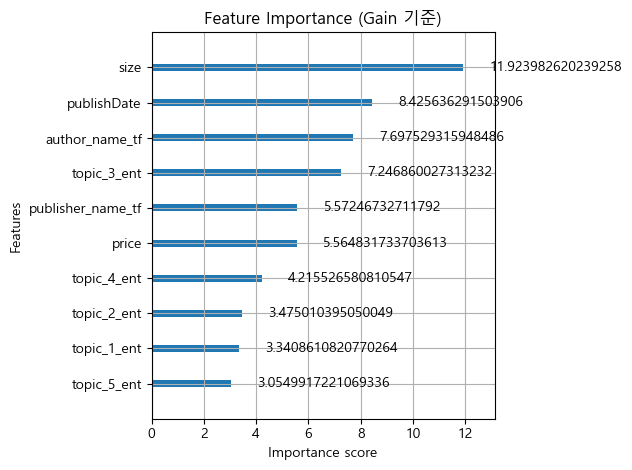

In [160]:
# 피처 중요도 시각화 (Gain 기준)
xgb.plot_importance(best_model, importance_type='gain', max_num_features=10)
plt.title("Feature Importance (Gain 기준)")
plt.tight_layout()
plt.show()

C:\Users\hc\AppData\Local\Temp\ipykernel_10904\501247281.py:8: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_val)


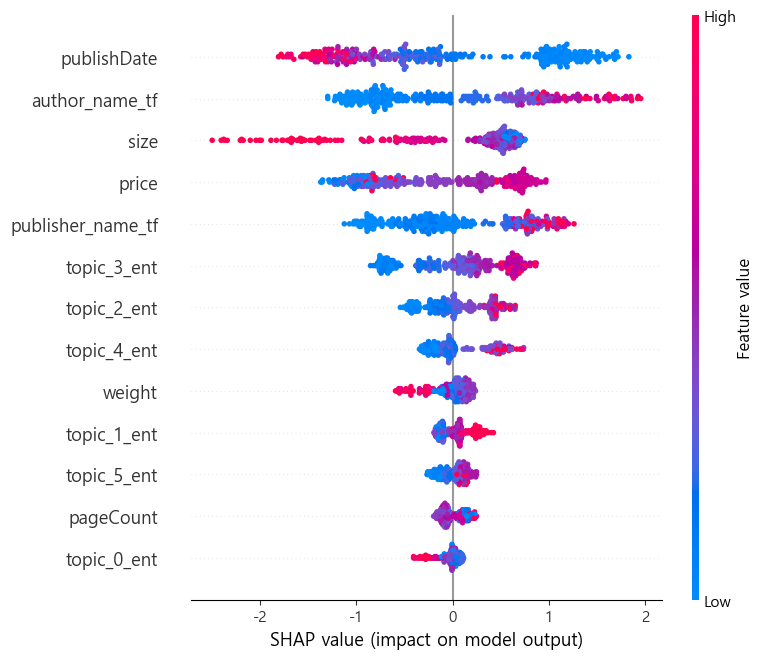

C:\Users\hc\AppData\Local\Temp\ipykernel_10904\501247281.py:9: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_val, plot_type="bar")


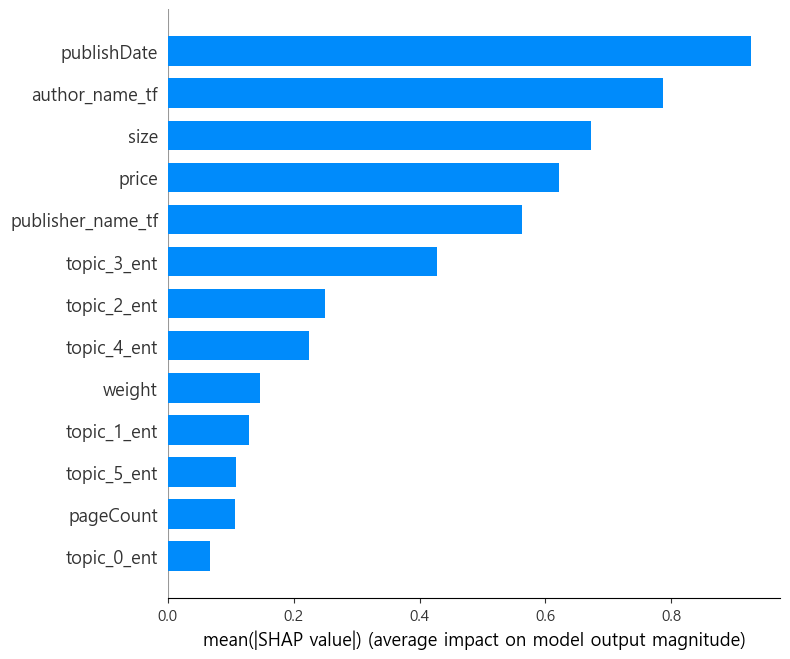

In [161]:
import shap

# SHAP 값 계산
explainer = shap.TreeExplainer(best_model, X_train)
shap_values = explainer(X_val)

# 요약 시각화 (Summary plot)
shap.summary_plot(shap_values, X_val)
shap.summary_plot(shap_values, X_val, plot_type="bar")

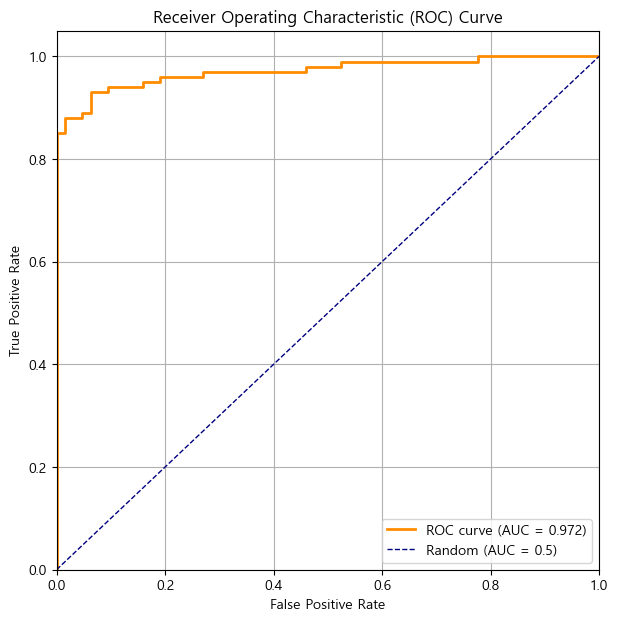

In [162]:
from sklearn.metrics import roc_curve, roc_auc_score, RocCurveDisplay
import matplotlib.pyplot as plt

# 예측 확률 (양성 클래스에 대한 확률)
y_proba = best_model.predict_proba(X_test)[:, 1]

# ROC 곡선 좌표 계산
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
auc = roc_auc_score(y_test, y_proba)

# ROC 곡선 시각화
plt.figure(figsize=(7, 7))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--', label='Random (AUC = 0.5)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


In [248]:
Application2 = {
    'publishDate': 1080.404101,
    'price': 14234.89144,
    'pageCount': 293,
    'size': 28750,
    'weight': 431.6688782,
    'author_name_tf': 3.9865,
    'publisher_name_tf': 35.09348613,
    'topic_0_ent': 0.004477564,
    'topic_1_ent': 0.0023982693,
    'topic_2_ent': 0.6357197,
    'topic_3_ent': 0.35068333,
    'topic_4_ent': 0.003722084,
    'topic_5_ent': 0.0029990016
}

X_2 = pd.DataFrame([Application2])

pred_label = best_model.predict(X_2)[0]

pred_proba = best_model.predict_proba(X_2)[0, 1]

print(f"분류 결과: {'베스트셀러' if pred_label == 1 else '일반'}")
print(f"베스트셀러일 확률: {pred_proba:.3f}")

분류 결과: 일반
베스트셀러일 확률: 0.125


In [253]:
def calculate_entropy(row):
    probs = row
    probs = probs[probs > 0]  # log(0) 방지
    return -np.sum(probs * np.log2(probs))

In [260]:
list=[0.004477564,0.0023982693,0.6357197,0.35068333,0.003722084,0.0029990016]
sum=0
for i in list:
    a=-np.sum(i * np.log2(i))
    sum+=a


In [261]:
sum

1.0565996223047802

In [262]:
# 1. 토픽값에 지수 변환 (exp, 0값 방지용 eps 추가)
eps = 1e-5
col_list=[]
for col in list:
    col_list.append(np.exp(col + eps))

In [263]:
col_list

[1.0044976481941732,
 1.0024111715098105,
 1.8883996040214557,
 1.420051771853053,
 1.0037390568972724,
 1.003013533189361]

In [264]:

# 2. 엔트로피 정규화 (0~1)
max_entropy = np.log2(len(col_list))
new_sum =sum/ max_entropy

In [265]:
# 3. 1 - 엔트로피 정규화값 계산
inv_list=[]
for i in col_list:
 inv_list.append(1 - i)

In [ ]:
col_list*inv_list

In [ ]:
for col in topic_cols:
    df[f'{col}_ent'] = df[col + '_exp'] * (df['inv_entropy'] ** k)


In [ ]:
# # 1. 토픽값에 지수 변환 (exp, 0값 방지용 eps 추가)
# eps = 1e-5
# for col in list:
#     df[col + '_exp'] = np.exp(df[col].replace(0, eps) + eps)

# # 2. 엔트로피 정규화 (0~1)
# max_entropy = np.log2(len(topic_cols))
# df['entropy_norm'] = df['entropy'] / max_entropy

# # 3. 1 - 엔트로피 정규화값 계산
# df['inv_entropy'] = 1 - df['entropy_norm']

# 4. k제곱 후, 지수 변환된 토픽값에 곱하기
k = 1
for col in topic_cols:
    df[f'{col}_ent'] = df[col + '_exp'] * (df['inv_entropy'] ** k)

# 5. 기존 토픽 컬럼, 엔트로피 관련 컬럼, 지수 변환만 한 컬럼 제외
drop_cols = topic_cols + ['entropy', 'entropy_norm', 'inv_entropy'] + [col + '_exp' for col in topic_cols]
X = df.drop(columns=drop_cols + ['isbn', 'title', 'label'])
y = df['label']

# 6. 결과 확인
print("최종 학습셋 피처 목록:", X.columns.tolist())
print(X[[f'{col}_ent' for col in topic_cols]].head())


In [ ]:
row=[0.004477564,0.0023982693]
a=calculate_entropy()

TypeError: 'float' object is not subscriptable

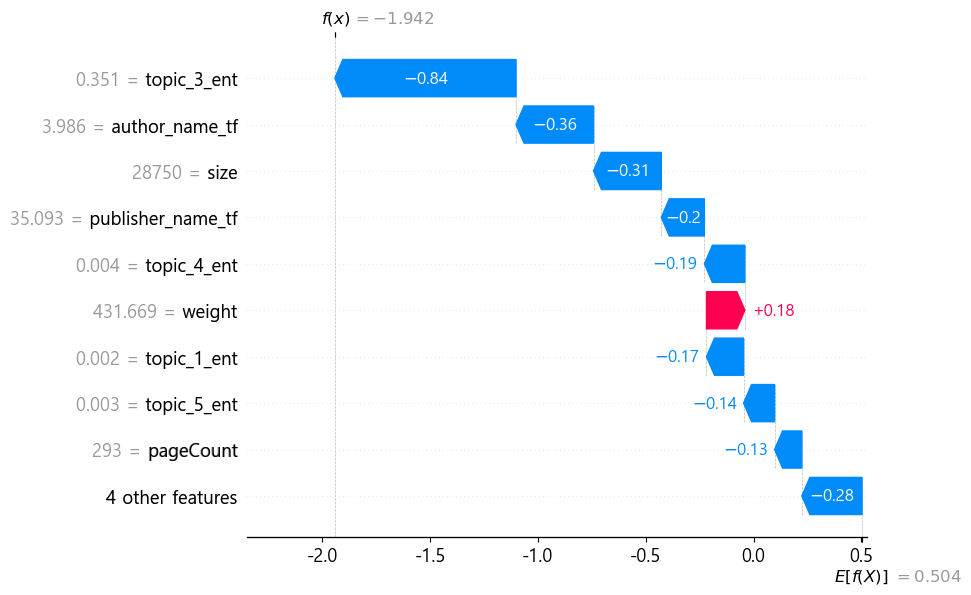

In [249]:
import shap

# 1. SHAP explainer 객체 생성 (트리 기반 모델에 최적화된 TreeExplainer 사용)
explainer = shap.Explainer(best_model)

# 2. 새 데이터에 대한 SHAP 값 계산
shap_values = explainer(X_2)

# 3. 해당 예측에 대한 SHAP 해석 시각화
# (1) Waterfall plot: 각 피처의 기여도와 누적 영향 시각화
shap.plots.waterfall(shap_values[0])

# (2) Force plot: 기준값에서 예측값까지, 각 피처의 영향력 시각화 (Jupyter에서만 잘 보임)
shap.plots.force(shap_values[0])
